# Converting database to pandas DataFrame
```Python
with read_engine.connect() as conn:
    conn.execute(text("SET TRANSACTION ISOLATION LEVEL READ COMMITTED"))

    # Read only the filtered points from the database
    points = gpd.read_postgis(
        sql_query,
        conn,
        geom_col='geometry'
    )

# 'points' contains only the data for trajectories with more than 1 point
points_df = pd.DataFrame(points.drop(columns=['geometry', 'descriptors']))
points_df['x'] = points.geometry.x
points_df['y'] = points.geometry.y

points_df.to_feather('points.feather')
```

In [ ]:
from datetime import datetime
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pysida.lib import GetSatPairs, get_deformation_from_pair, get_nn_distances

DAYS_IN_SECONDS = 24 * 60 * 60

In [2]:
# Read feather file and convert to a DataFrame usable by pysida
feather_file = '../points.feather'
points = pd.read_feather(feather_file)
df = points[['image_id', 'trajectory_id', 'time', 'x', 'y', 'corr']].copy().rename(columns={'image_id':'i', 'trajectory_id': 'g', 'time':'d', 'x':'x', 'y':'y', 'corr':'q'})

In [3]:
date_begin = datetime(2020, 1, 10)
date_end = datetime(2020, 1, 15)

pairs_list = []
defors_list =[]

# get pairs without or with filtering by poisson disk
for poisson_disk_radius in [None, 2000]:
    # Get pairs for a short period of time
    gsp = GetSatPairs(df, poisson_disk_radius=poisson_disk_radius)
    pairs = gsp.get_all_pairs(date_begin, date_end)

    # compute deformation for selected pairs
    with Pool(4) as p:
        defors = p.map(get_deformation_from_pair, pairs)

    pairs_list.append(pairs)
    defors_list.append(defors)

/Users/antonk/py/ice_deformation_analysis/pysida/lib.py:463: RuntimeWarning: invalid value encountered in sqrt
  ap_ratio = area**0.5 / perim


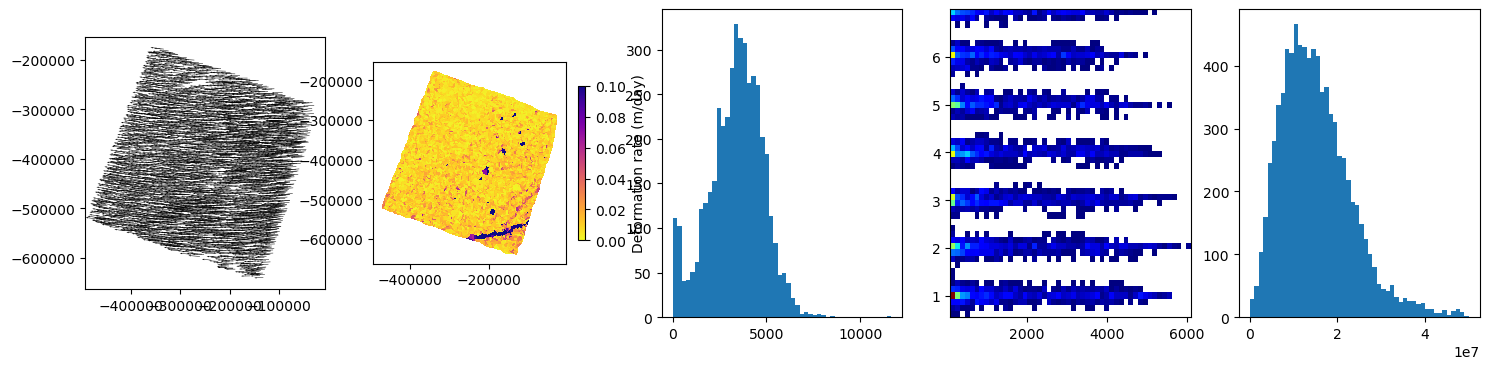

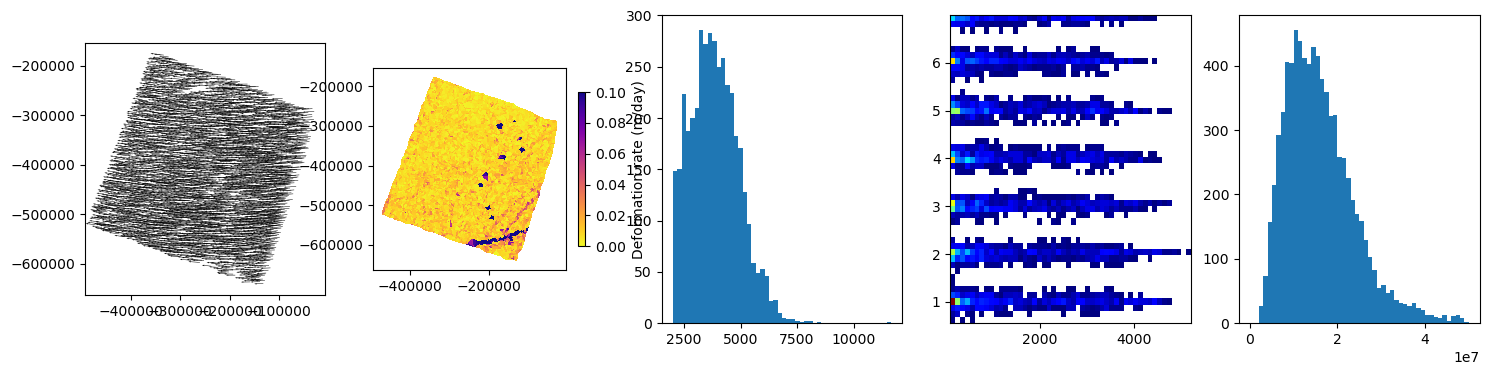

In [4]:
for pairs, defors in zip(pairs_list, defors_list):
    # get sizes and time differences of pairs
    sizes = [pair.x0.size for pair in pairs]
    time_difs = [(pair.d1 - pair.d0).total_seconds()/ DAYS_IN_SECONDS for pair in pairs]

    # plot deformation, drift, histograms of differences between points and deformation
    for pair, defor in zip(pairs, defors):
        if pair.d0 == pd.Timestamp('2020-01-05 16:12:33') and pair.d1 == pd.Timestamp('2020-01-10 16:20:45'):
            distances = get_nn_distances(pair)        
            fig, axs = plt.subplots(1, 5, figsize=(18, 4))
            qui0 = axs[0].quiver(pair.x0, pair.y0, pair.x1 - pair.x0, pair.y1 - pair.y0, angles='xy', scale_units='xy', scale=1, color='k', width=0.002)
            axs[0].set_aspect('equal')

            trp1 = axs[1].tripcolor(pair.x0, pair.y0, pair.t, defor.e2 * 24 * 60 * 60, clim=[0,0.1], mask=~pair.g, cmap='plasma_r')
            plt.colorbar(trp1, ax=axs[1], shrink=0.5, label='Deformation rate (m/day)')
            axs[1].set_aspect('equal')

            _ = axs[2].hist(distances, bins=50)

            _ = axs[3].hist2d(sizes, time_difs, bins=[50, 50], cmap='jet', cmin=1)

            _ = axs[4].hist(pair.a[pair.g], bins=50, range=[0, 0.5e8])
            plt.show()
            break        

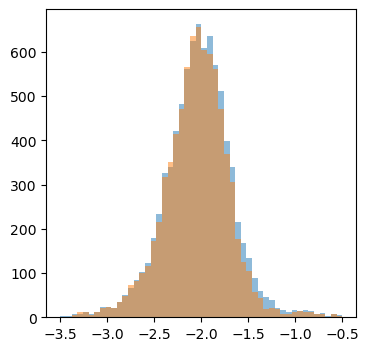

In [25]:
plt.figure(figsize=(4, 4))
for pairs, defors in zip(pairs_list, defors_list):
    # get sizes and time differences of pairs and plot
    sizes = [pair.x0.size for pair in pairs]
    time_difs = [(pair.d1 - pair.d0).total_seconds()/ DAYS_IN_SECONDS for pair in pairs]

    # plot deformation, drift, histograms of differences between points and deformation
    for pair, defor in zip(pairs, defors):
        if pair.d0 == pd.Timestamp('2020-01-05 16:12:33') and pair.d1 == pd.Timestamp('2020-01-10 16:20:45'):
            plt.hist(np.log10(defor.e2[pair.g] * 24 * 60 * 60), bins=50, range=[-3.5, -0.5], alpha=0.5)
